In [ ]:
import numpy as np
import pandas as pd

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score



import xgboost as xgb
from xgboost import XGBRegressor



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_org=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Interpretable Learning /CHLA/4site_season_work.csv")
df_org['DATE'] = pd.to_datetime(df_org['DATE'])

DATA 전처리

In [ ]:
df_B = df_org.loc[df_org.DATE >= '2017-10-01',:]
### 결측치가 많아서 2017.10이후 자료를 이용하여 모형 구축

df_C=df_B.reset_index(drop=True)

df_A=df_C[['DATE','SEASON','TEMP_HD','PH_HD','EC_HD','DO_HD','TUR_HD','CHLA_HD',
             'TEMP_DC','PH_DC','EC_DC','DO_DC','CHLA_DC',
             'TEMP_JG','PH_JG','EC_JG','DO_JG','CHLA_JG']]


In [ ]:
df_B=pd.get_dummies(df_A, columns = ['SEASON'],drop_first=True)

In [ ]:
df_B.describe().T

,count,mean,std,min,25%,50%,75%,max
TEMP_HD,1219.0,11.845037,5.179560,4.0,7.400,10.10,16.25,22.8
PH_HD,1219.0,7.115669,0.247733,6.5,6.900,7.10,7.30,7.7
EC_HD,1219.0,148.618540,22.474755,85.0,139.000,154.00,164.00,182.0
DO_HD,1211.0,7.730471,2.572359,0.5,6.000,8.00,9.95,12.5
TUR_HD,1210.0,1.425950,2.874463,0.1,0.300,0.60,1.10,23.7
CHLA_HD,1150.0,3.974087,2.248134,0.8,2.425,3.50,4.80,22.9
TEMP_DC,1256.0,16.882803,8.137750,3.2,8.900,17.10,24.20,33.7
PH_DC,1256.0,7.944188,0.830925,6.6,7.400,7.60,8.60,10.4
EC_DC,1243.0,150.684634,22.676901,72.0,138.000,154.00,165.00,220.0
DO_DC,1250.0,9.822960,1.747846,4.1,8.600,9.85,11.10,14.9


In [ ]:
df_B

,DATE,TEMP_HD,PH_HD,EC_HD,DO_HD,TUR_HD,CHLA_HD,TEMP_DC,PH_DC,EC_DC,DO_DC,CHLA_DC,TEMP_JG,PH_JG,EC_JG,DO_JG,CHLA_JG,SEASON_2,SEASON_3,SEASON_4
0,2017-10-01,21.2,6.9,165.0,3.6,0.5,2.5,24.1,7.5,162.0,7.3,9.6,23.9,8.4,160.0,8.4,22.9,0,1,0
1,2017-10-02,21.2,7.0,164.0,3.6,0.5,2.7,24.1,7.7,162.0,7.7,11.0,23.8,8.4,161.0,8.4,22.2,0,1,0
2,2017-10-03,21.6,7.0,165.0,3.8,0.5,3.9,24.0,7.7,162.0,7.7,10.6,23.8,8.1,161.0,7.7,22.1,0,1,0
3,2017-10-04,21.3,7.0,165.0,3.8,0.5,4.9,24.2,7.7,162.0,7.6,9.7,23.7,7.8,162.0,7.0,20.9,0,1,0
4,2017-10-05,21.3,7.0,165.0,4.3,0.5,3.2,23.7,7.6,162.0,7.6,10.4,23.4,7.6,163.0,6.4,17.3,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1272,2021-03-27,7.6,7.3,127.0,10.7,0.2,4.2,10.9,7.8,127.0,10.8,4.1,13.2,7.3,177.0,11.2,NaN,0,0,0
1273,2021-03-28,7.5,7.3,127.0,10.5,0.3,4.5,10.4,7.9,131.0,10.7,7.4,12.6,7.0,177.0,10.6,NaN,0,0,0
1274,2021-03-29,8.3,7.3,125.0,10.6,0.3,4.6,11.0,7.8,127.0,10.7,5.0,12.4,6.9,175.0,10.5,NaN,0,0,0
1275,2021-03-30,8.9,7.3,125.0,10.8,0.3,4.4,11.0,7.7,122.0,10.7,2.9,13.3,6.5,175.0,10.7,16.5,0,0,0


# Train test 나누기



In [ ]:
c_tt='2020-04-01' #0.8
#c_tt='2019-10-01' #

train_org = df_B.loc[df_B.DATE < c_tt,:]
test_org = df_B.loc[df_B.DATE >= c_tt,:]

In [ ]:
print(len(train_org)/(len(train_org)+len(test_org)), train_org.shape, test_org.shape)

0.7141738449490994 (912, 20) (365, 20)


In [ ]:
train_org.tail(3)

,DATE,TEMP_HD,PH_HD,EC_HD,DO_HD,TUR_HD,CHLA_HD,TEMP_DC,PH_DC,EC_DC,DO_DC,CHLA_DC,TEMP_JG,PH_JG,EC_JG,DO_JG,CHLA_JG,SEASON_2,SEASON_3,SEASON_4
909,2020-03-29,7.6,7.3,157.0,10.2,0.3,3.2,11.4,7.9,157.0,11.3,4.7,12.4,8.1,159.0,11.4,13.6,0,0,0
910,2020-03-30,7.7,7.3,157.0,10.3,0.3,3.4,12.3,7.9,158.0,11.1,4.5,13.1,7.9,158.0,11.3,10.4,0,0,0
911,2020-03-31,7.8,7.3,157.0,10.2,0.3,3.5,13.4,7.9,157.0,10.9,4.4,14.0,8.2,159.0,11.6,10.7,0,0,0


In [ ]:
train_org.isnull().sum(axis=0).sum()

412

knn_imputation

In [ ]:
from sklearn.impute import KNNImputer
KI = KNNImputer(n_neighbors = 3)
A_TEMP=train_org.drop(['DATE'], axis=1)
KI.fit(A_TEMP)
train_org_temp = pd.DataFrame(KI.transform(A_TEMP), columns = A_TEMP.columns)
train_org_fill=pd.concat([train_org.DATE, train_org_temp], axis=1)

In [ ]:
train_org_fill.isnull().sum(axis=0).sum()

0

### Linear Regression

In [ ]:
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
train_org_fill

,DATE,TEMP_HD,PH_HD,EC_HD,DO_HD,TUR_HD,CHLA_HD,TEMP_DC,PH_DC,EC_DC,DO_DC,CHLA_DC,TEMP_JG,PH_JG,EC_JG,DO_JG,CHLA_JG,SEASON_2,SEASON_3,SEASON_4
0,2017-10-01,21.2,6.9,165.0,3.6,0.5,2.5,24.1,7.5,162.0,7.3,9.6,23.9,8.4,160.0,8.4,22.9,0.0,1.0,0.0
1,2017-10-02,21.2,7.0,164.0,3.6,0.5,2.7,24.1,7.7,162.0,7.7,11.0,23.8,8.4,161.0,8.4,22.2,0.0,1.0,0.0
2,2017-10-03,21.6,7.0,165.0,3.8,0.5,3.9,24.0,7.7,162.0,7.7,10.6,23.8,8.1,161.0,7.7,22.1,0.0,1.0,0.0
3,2017-10-04,21.3,7.0,165.0,3.8,0.5,4.9,24.2,7.7,162.0,7.6,9.7,23.7,7.8,162.0,7.0,20.9,0.0,1.0,0.0
4,2017-10-05,21.3,7.0,165.0,4.3,0.5,3.2,23.7,7.6,162.0,7.6,10.4,23.4,7.6,163.0,6.4,17.3,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
907,2020-03-27,7.6,7.3,157.0,10.1,0.3,3.7,11.8,7.8,157.0,11.0,5.6,12.6,7.8,159.0,11.2,16.8,0.0,0.0,0.0
908,2020-03-28,7.5,7.3,157.0,10.2,0.3,3.3,11.4,7.9,157.0,11.1,4.9,12.2,8.2,159.0,11.5,16.6,0.0,0.0,0.0
909,2020-03-29,7.6,7.3,157.0,10.2,0.3,3.2,11.4,7.9,157.0,11.3,4.7,12.4,8.1,159.0,11.4,13.6,0.0,0.0,0.0
910,2020-03-30,7.7,7.3,157.0,10.3,0.3,3.4,12.3,7.9,158.0,11.1,4.5,13.1,7.9,158.0,11.3,10.4,0.0,0.0,0.0


In [ ]:
fit = ols('CHLA_HD ~  TEMP_HD + PH_HD +	EC_HD +	DO_HD	+ TUR_HD	+ TEMP_DC	+ PH_DC	+ EC_DC	+ DO_DC	+ CHLA_DC	+ TEMP_JG	+ PH_JG	+ EC_JG	+ DO_JG	+ CHLA_JG', data=train_org_fill).fit()

In [ ]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                CHLA_HD   R-squared:                       0.279
Model:                            OLS   Adj. R-squared:                  0.267
Method:                 Least Squares   F-statistic:                     23.15
Date:                Mon, 15 Nov 2021   Prob (F-statistic):           4.80e-54
Time:                        01:40:16   Log-Likelihood:                -1794.7
No. Observations:                 912   AIC:                             3621.
Df Residuals:                     896   BIC:                             3698.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -23.6701      5.649     -4.190      0.000     -34.757     -12.583
TEMP_HD        0.3351      0.048      6.923      0.000       0.240       0.430
PH_HD          2.7412      0.975      2.812      0.005       0.828       4.654
EC_HD         -0.0260      0.010     -2.688      0.007      -0.045      -0.007
DO_HD          0.4882      0.106      4.588      0.000       0.279       0.697
TUR_HD        -0.3402      0.097     -3.519      0.000      -0.530      -0.150
TEMP_DC        0.2261      0.079      2.864      0.004       0.071       0.381
PH_DC          0.0971      0.332      0.292      0.770      -0.554       0.749
EC_DC         -0.0073      0.008     -0.929      0.353      -0.023       0.008
DO_DC          0.1633      0.100      1.642      0.101      -0.032       0.359
CHLA_DC        0.0644      0.012      5.417      0.000       0.041       0.088
TEMP_JG       -0.2470      0.057     -4.328      0.000      -0.359      -0.135
PH_JG          0.1711      0.217      0.790      0.430      -0.254       0.596
EC_JG          0.0157      0.004      3.517      0.000       0.007       0.024
DO_JG         -0.0513      0.082     -0.629      0.529      -0.211       0.109
CHLA_JG       -0.0007      0.008     -0.087      0.930      -0.016       0.015
==============================================================================
Omnibus:                      792.031   Durbin-Watson:                   0.333
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            31208.631
Skew:                           3.766   Prob(JB):                         0.00
Kurtosis:                      30.650   Cond. No.                     2.80e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.8e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# DATA SPLIT

In [ ]:
test_org_RNA=test_org.dropna()

x_train=train_org_fill.drop(['DATE','CHLA_HD'], axis=1)
y_train=train_org_fill['CHLA_HD']

x_test=test_org_RNA.drop(['DATE','CHLA_HD'], axis=1)
y_test=test_org_RNA['CHLA_HD']

test_org_RNA.isnull().sum(axis=0).sum()

0

xgboost_optimzied: nit=100, max_depth=5

In [ ]:
dytest_c1

,CHLA_HD
0,3.9
1,4.5
2,3.0
3,3.3
4,3.7
...,...
197,3.7
198,3.9
199,3.8
200,4.4


In [ ]:
rf_c1 = XGBRegressor(random_state=153, n_estimators=100, learning_rate=0.1, max_depth=2, n_jobs=-1)
rf_c1.fit(x_train , y_train)
pred_c1 = rf_c1.predict(x_test)
dpred_c1 = pd.DataFrame(pred_c1)

[01:40:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
dytest_c1 = pd.DataFrame(y_test).reset_index(drop=True)

inv_y = dytest_c1
inv_yhat = dpred_c1

from sklearn.metrics import r2_score
r_2f = r2_score(inv_y,inv_yhat)

print('R^2 method1: %.4f' % r_2f)

from sklearn.metrics import mean_squared_error
from math import sqrt
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

R^2 method1: 0.6031
Test RMSE: 1.872


In [ ]:
from xgboost import plot_importance
from matplotlib.pylab import rcParams

In [ ]:
rcParams['figure.figsize'] = 10, 10

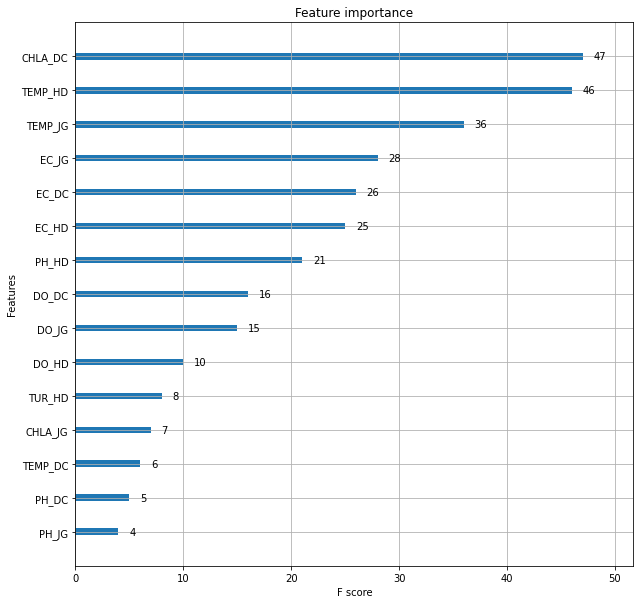

In [ ]:
plot_importance(rf_c1)
plt.show()

# Visualization

https://pdpbox.readthedocs.io/en/latest/target_plot.html

In [ ]:
!pip install pdpbox

     |████████████████████████████████| 34.0 MB 42 kB/s 
     |████████████████████████████████| 13.1 MB 6.9 kB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.1-py3-none-any.whl size=35758225 sha256=4b256168011911d2cfa3586dbe96defae405bcdbabc965fd13a39787eb883ee2
  Stored in directory: /root/.cache/pip/wheels/f4/d0/1a/b80035625c53131f52906a6fc4dd690d8efd2bf8af6a4015eb
Successfully built pdpbox
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
from pdpbox import pdp, info_plots

In [ ]:
data =  pd.concat([x_train,y_train],axis=1)
#data =  pd.concat([x_test,y_test],axis=1)
ctt=len(data.columns)

features =   data.columns[:ctt-1]
target =  data.columns[ctt-1]

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


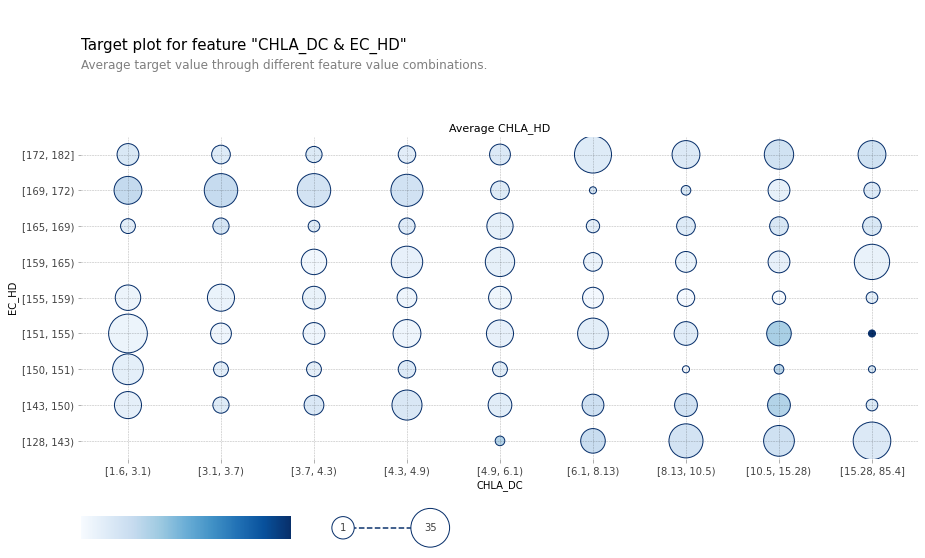

In [ ]:
fig, axes, summary_df = info_plots.target_plot_interact(
    df = data, annotate=True,
    features = ['CHLA_DC', 'EC_HD'],
    feature_names = ['CHLA_DC', 'EC_HD'],
    target = target 
)


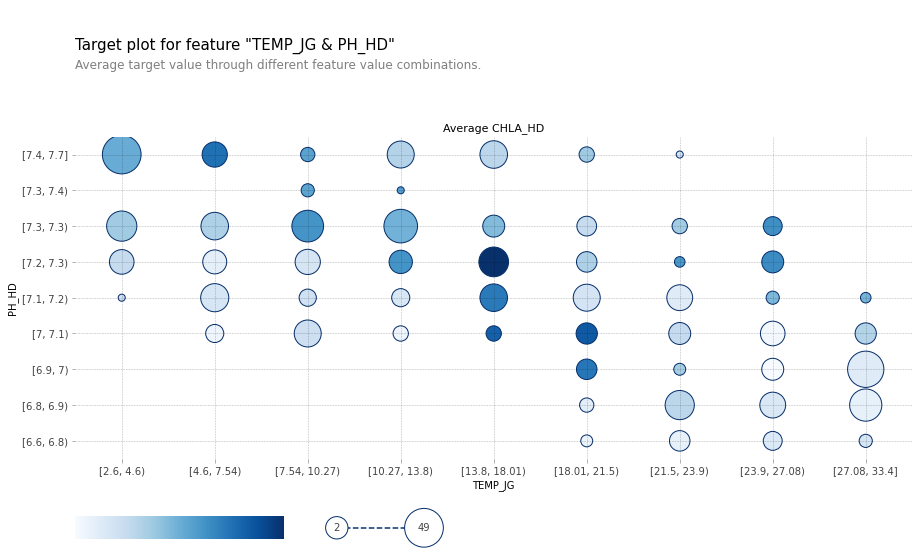

In [ ]:

fig, axes, summary_df = info_plots.target_plot_interact(
    df = data, annotate=True, 
    features = ['TEMP_JG', 'PH_HD'],
    feature_names = ['TEMP_JG', 'PH_HD'],
    target = target # 문제11
)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


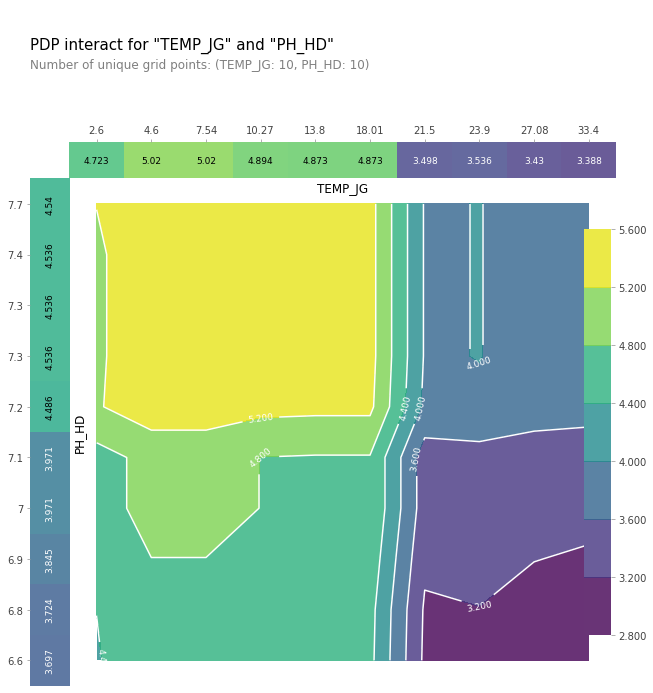

In [ ]:
pdp_interaction = pdp.pdp_interact(
    model = rf_c1,
    dataset=data,
    model_features = features,
    features=['TEMP_JG', 'PH_HD']
)

fig, axes = pdp.pdp_interact_plot(
    pdp_interact_out = pdp_interaction,
    feature_names=['TEMP_JG', 'PH_HD'],
    plot_type = 'contour',
    x_quantile=True,
    plot_pdp=True
)


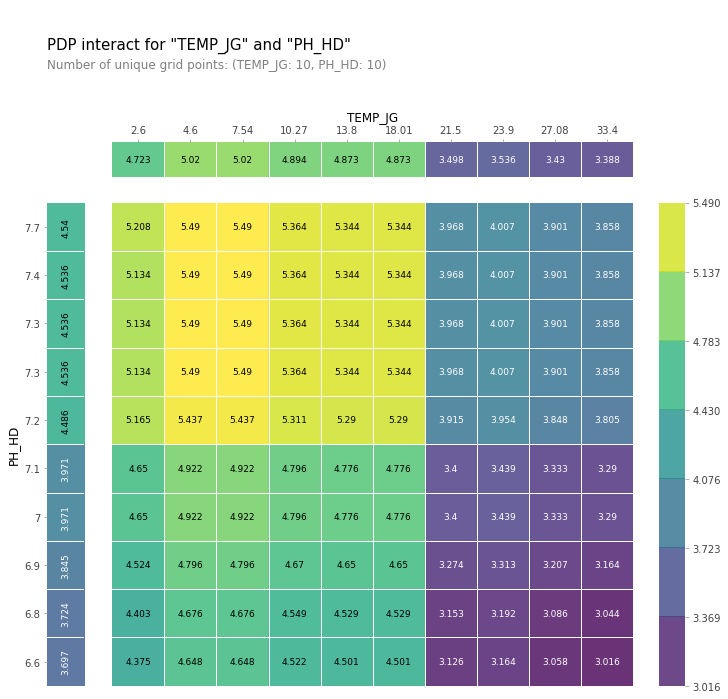

In [ ]:
pdp_interaction = pdp.pdp_interact(
    model = rf_c1,
    dataset=data,
    model_features = features,
    features=['TEMP_JG', 'PH_HD']
)

fig, axes = pdp.pdp_interact_plot(
    pdp_interact_out = pdp_interaction,
    feature_names=['TEMP_JG', 'PH_HD'],
    plot_type = 'grid',
    x_quantile=True,
    plot_pdp=True
)


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


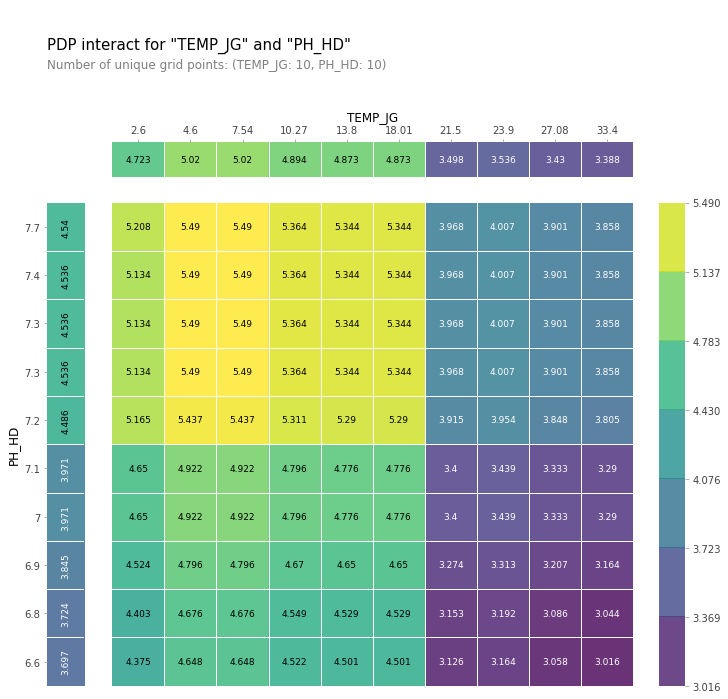

In [ ]:
pdp_interaction = pdp.pdp_interact(
    model = rf_c1,
    dataset=data,
    model_features = features,
    features=['TEMP_JG', 'PH_HD']
)

fig, axes = pdp.pdp_interact_plot(
    pdp_interact_out = pdp_interaction,
    feature_names=['TEMP_JG', 'PH_HD'],
    plot_type = 'grid',
    x_quantile=True,
    plot_pdp=True
)

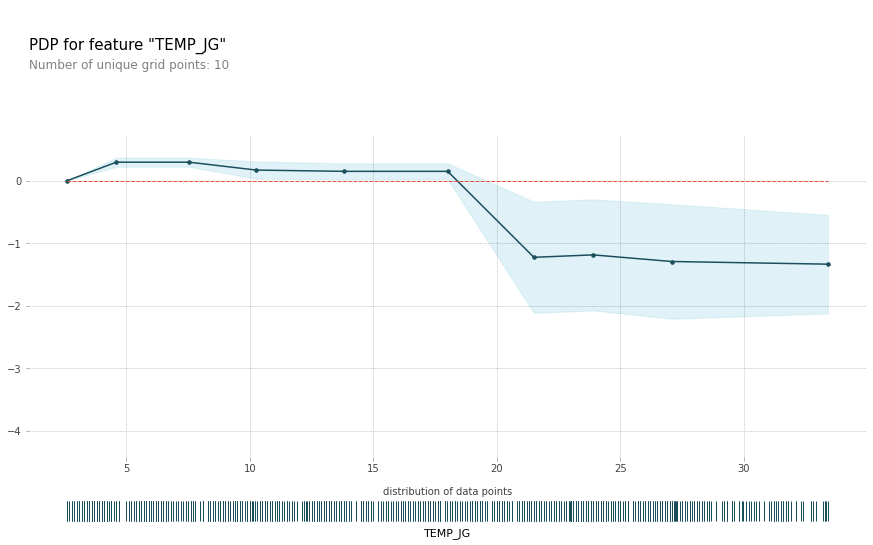

In [ ]:
pdp_tem = pdp.pdp_isolate(
    model = rf_c1,
    dataset = data,
    model_features=features,
    feature = 'TEMP_JG'
)
fig, axes = pdp.pdp_plot(
    pdp_tem,
    'TEMP_JG',
    plot_lines=False,
    frac_to_plot=0.5,
    plot_pts_dist = True
)

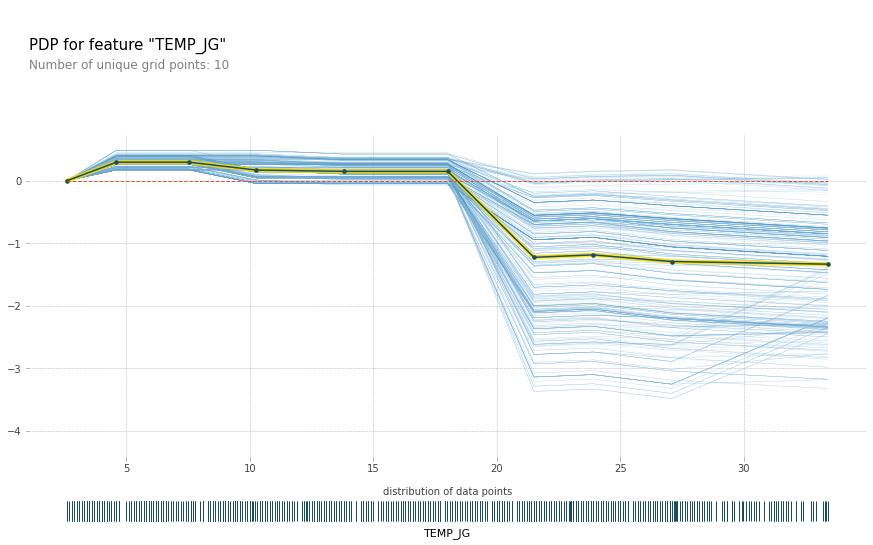

In [ ]:
fig, axes = pdp.pdp_plot(
    pdp_tem,
    'TEMP_JG',
    plot_lines=True,
    frac_to_plot=0.5,
    plot_pts_dist = True
)

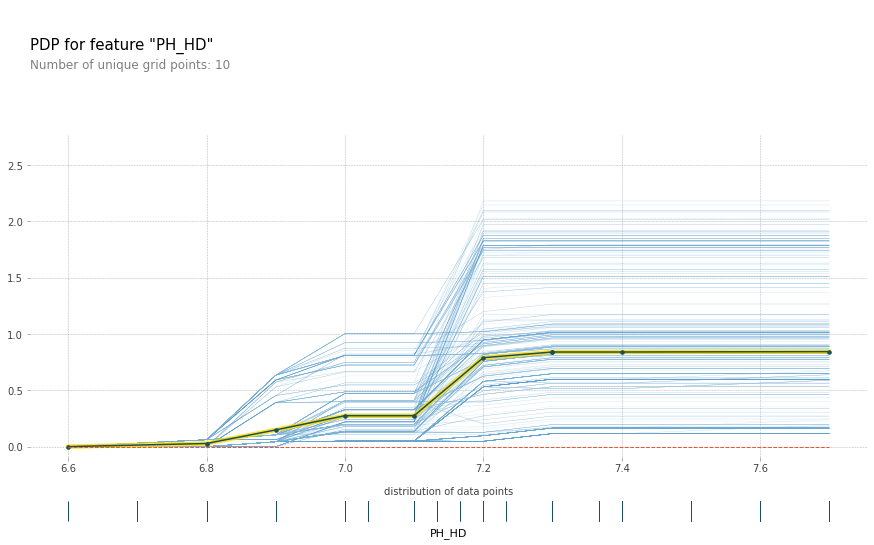

In [ ]:
pdp_ph = pdp.pdp_isolate(
    model = rf_c1,
    dataset = data,
    model_features=features,
    feature = 'PH_HD'
)
fig, axes = pdp.pdp_plot(
    pdp_ph,
    'PH_HD',
    plot_lines=True,
    frac_to_plot=0.5,
    plot_pts_dist = True
)

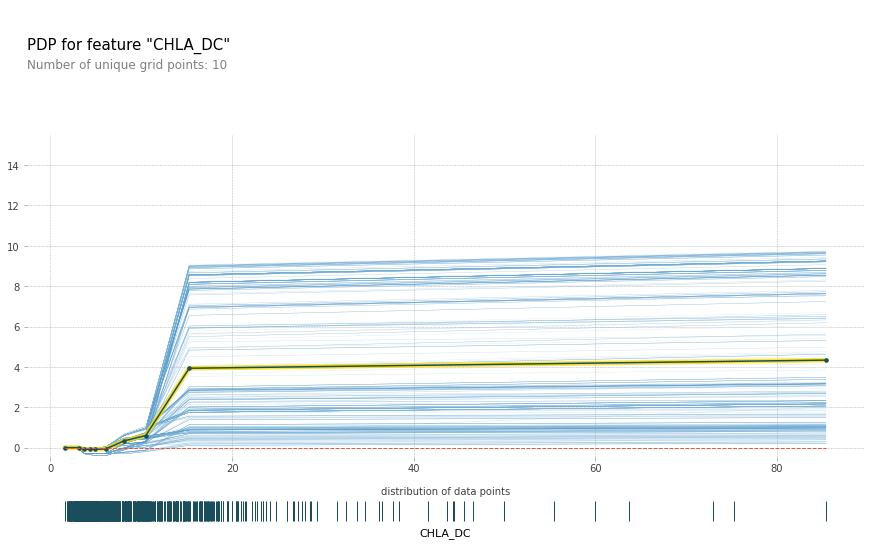

In [ ]:
pdp_ch = pdp.pdp_isolate(
    model = rf_c1,
    dataset = data,
    model_features=features,
    feature = 'CHLA_DC'
)
fig, axes = pdp.pdp_plot(
    pdp_ch,
    'CHLA_DC',
    plot_lines=True,
    frac_to_plot=0.5,
    plot_pts_dist = True
)

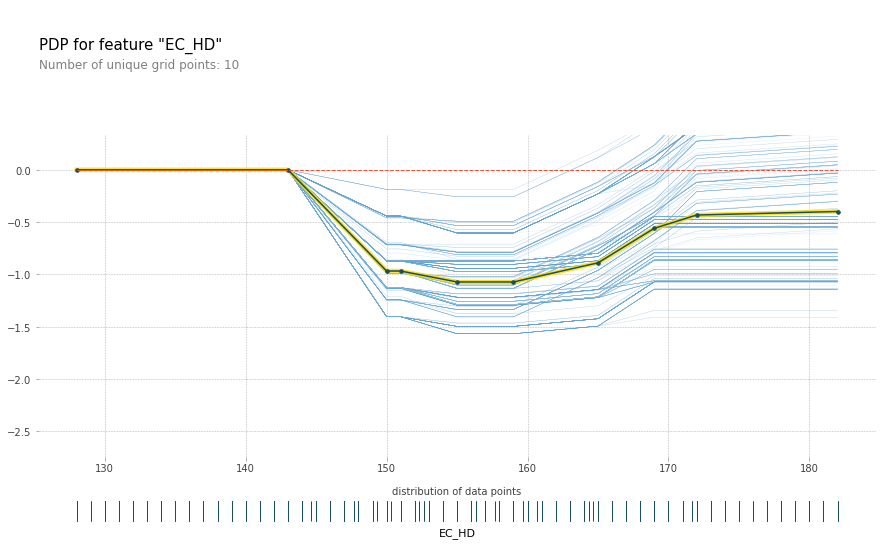

In [ ]:
pdp_ech = pdp.pdp_isolate(
    model = rf_c1,
    dataset = data,
    model_features=features,
    feature = 'EC_HD'
)
fig, axes = pdp.pdp_plot(
    pdp_ech,
    'EC_HD',
    plot_lines=True,
    frac_to_plot=0.5,
    plot_pts_dist = True
)

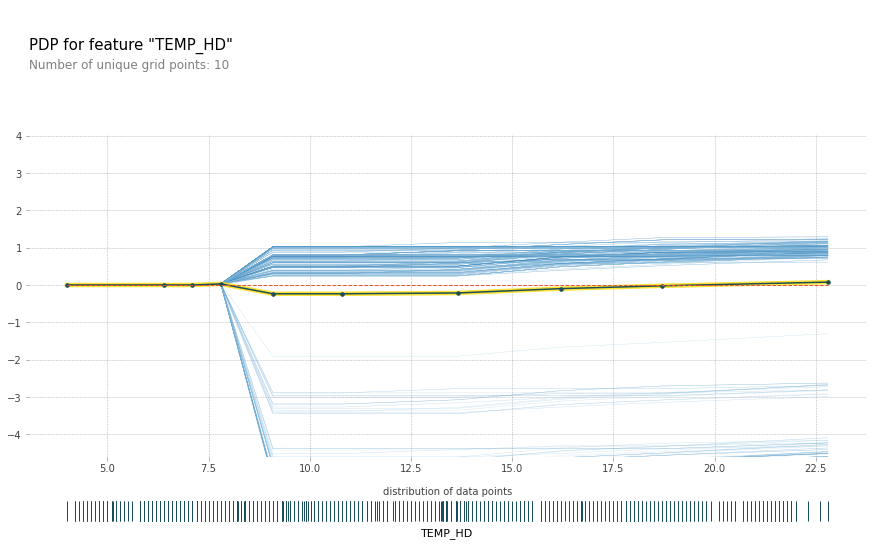

In [ ]:
pdp_temp = pdp.pdp_isolate(
    model = rf_c1,
    dataset = data,
    model_features=features,
    feature = 'TEMP_HD'
)
fig, axes = pdp.pdp_plot(
    pdp_temp,
    'TEMP_HD',
    plot_lines=True,
    frac_to_plot=0.5,
    plot_pts_dist = True
)

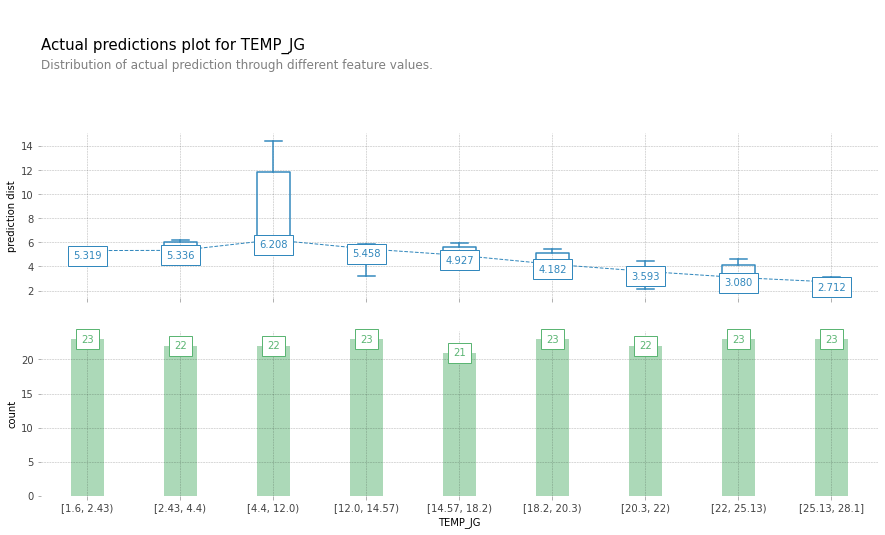

In [ ]:
fig, axes, summary_df = info_plots.actual_plot(
    model = rf_c1,
    X = x_test,
    feature = 'TEMP_JG',
    feature_name = 'TEMP_JG',
    predict_kwds={}
) 

In [ ]:
x_test

,TEMP_HD,PH_HD,EC_HD,DO_HD,TUR_HD,TEMP_DC,PH_DC,EC_DC,DO_DC,CHLA_DC,TEMP_JG,PH_JG,EC_JG,DO_JG,CHLA_JG,SEASON_2,SEASON_3,SEASON_4
912,7.9,7.3,158.0,10.1,0.4,13.3,7.9,158.0,11.0,4.4,13.7,8.2,159.0,11.6,11.6,0,0,0
913,8.0,7.3,158.0,10.1,0.3,12.6,8.0,158.0,11.2,4.4,13.6,8.2,159.0,11.5,10.3,0,0,0
928,8.4,7.3,157.0,9.5,0.2,14.0,8.2,158.0,10.9,4.4,14.7,8.0,160.0,10.3,11.8,0,0,0
929,8.8,7.3,158.0,9.6,0.2,14.6,8.1,157.0,10.8,4.4,15.0,8.0,158.0,10.2,13.0,0,0,0
930,8.1,7.2,158.0,9.4,0.2,14.2,8.1,158.0,10.9,4.5,14.8,8.1,158.0,10.2,15.2,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1269,7.5,7.3,127.0,11.1,0.2,9.3,7.7,120.0,11.3,3.3,12.4,7.8,180.0,10.9,21.3,0,0,0
1270,8.7,7.4,125.0,11.0,0.2,10.0,7.7,122.0,11.3,2.9,12.5,7.7,180.0,10.8,19.9,0,0,0
1271,8.4,7.3,127.0,10.9,0.2,10.9,7.8,124.0,11.2,2.8,13.9,7.5,179.0,11.0,18.1,0,0,0
1275,8.9,7.3,125.0,10.8,0.3,11.0,7.7,122.0,10.7,2.9,13.3,6.5,175.0,10.7,16.5,0,0,0


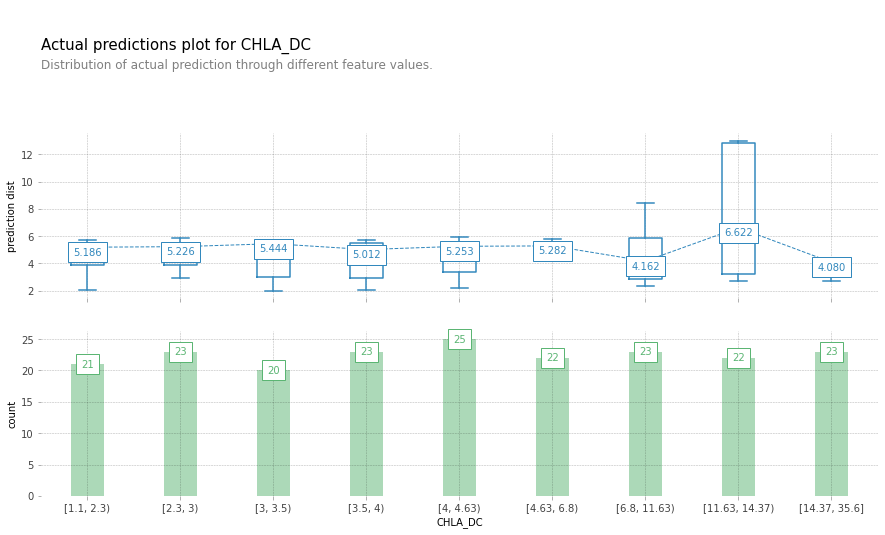

In [ ]:
fig, axes, summary_df = info_plots.actual_plot(
    model = rf_c1,
    X = x_test,
    feature = 'CHLA_DC',
    feature_name = 'CHLA_DC',
    predict_kwds={}
) 

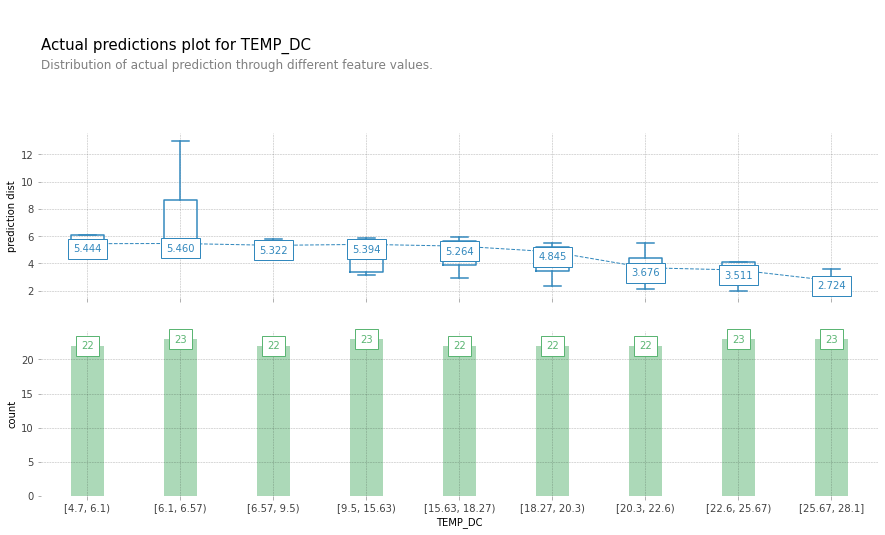

In [ ]:
fig, axes, summary_df = info_plots.actual_plot(
    model = rf_c1,
    X = x_test,
    feature = 'TEMP_DC',
    feature_name = 'TEMP_DC',
    predict_kwds={}
) 

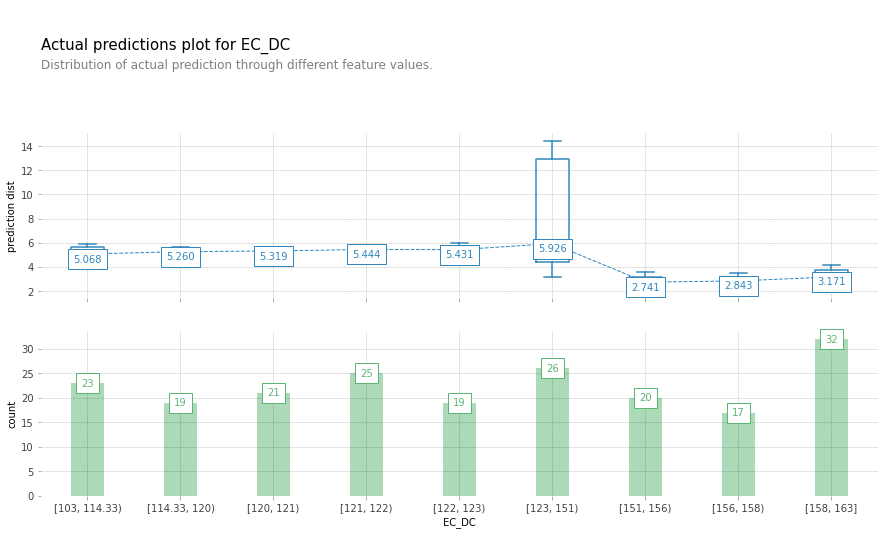

In [ ]:
fig, axes, summary_df = info_plots.actual_plot(
    model = rf_c1,
    X = x_test,
    feature = 'EC_DC',
    feature_name = 'EC_DC',
    predict_kwds={}
) 

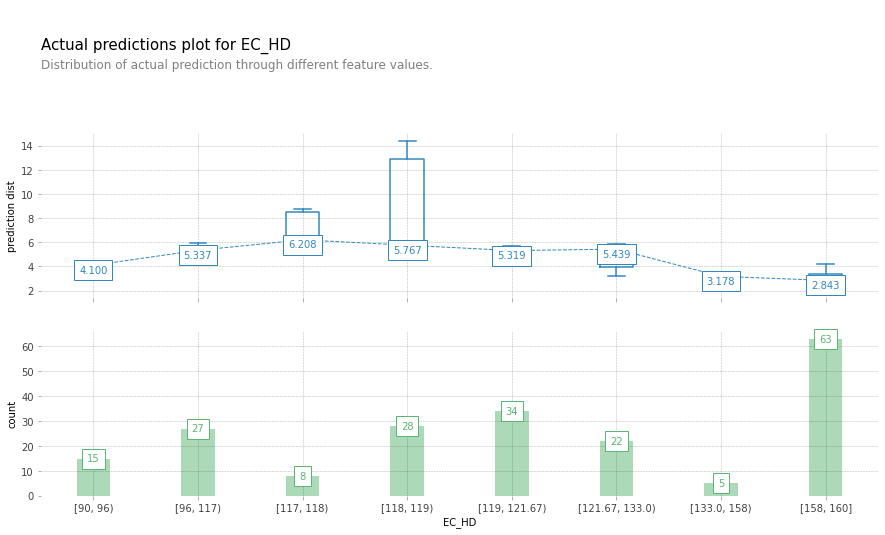

In [ ]:
fig, axes, summary_df = info_plots.actual_plot(
    model = rf_c1,
    X = x_test,
    feature = 'EC_HD',
    feature_name = 'EC_HD',
    predict_kwds={}
) 

# shap value

In [ ]:
!pip install shap

     |████████████████████████████████| 356 kB 5.1 MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491643 sha256=0109347c5498a3c3ba8a5600802e6dea9a8a61528e21ec23e04e6a23ef15624a
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap


In [ ]:
## https://www.kaggle.com/dansbecker/shap-values
## https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values

import shap
import skimage
shap.initjs()
skimage.__version__

'0.16.2'

In [ ]:
rf_c1

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=2, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=153,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [ ]:
explainer =  shap.TreeExplainer(rf_c1)
shap_values =  explainer.shap_values(x_test) 
## shap 계산: 전체 데이터

In [ ]:
shap_interaction_values = shap.TreeExplainer(rf_c1).shap_interaction_values(x_test)

In [ ]:
#X, y = shap.datasets
#X_display,y_display = shap.datasets.nhanesi(display=True)
# 이진 분류에 대한 shap_plot 작성시 x_display, y_display가 필요한데 
# 이를 위해서는 이에 해당하는 table을 작성해야 한다

In [ ]:
shap.initjs() 

#ch_p=0  # 분석할 값,  April 1 2020

ch_p=65  # 분석할 값, July 17, 2020

shap.force_plot(explainer.expected_value, shap_values[ch_p,:], x_test.iloc[ch_p,:]) 

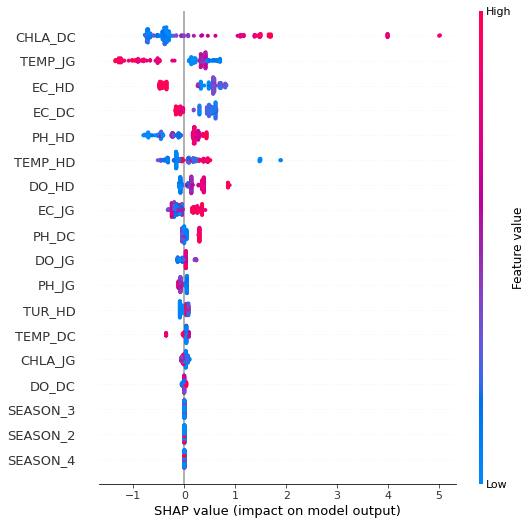

In [ ]:
shap.summary_plot(shap_values, x_test)

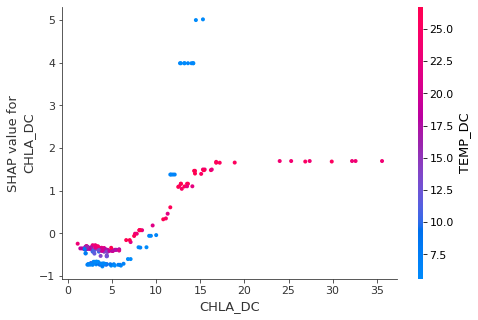

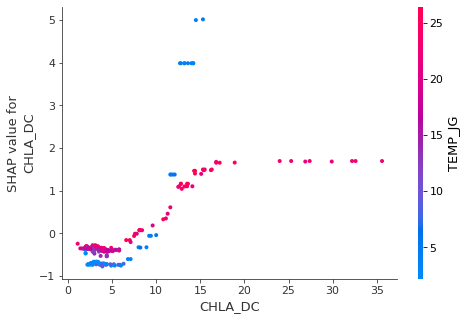

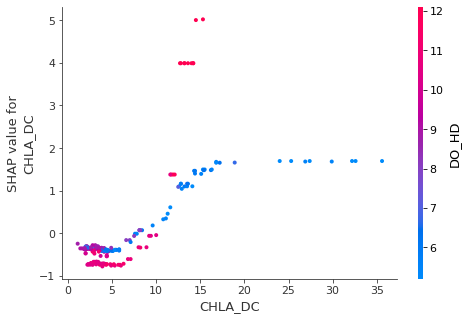

In [ ]:
inds = shap.approximate_interactions("CHLA_DC", shap_values, x_test)
for i in range(3):
  shap.dependence_plot("CHLA_DC", shap_values, x_test, interaction_index=inds[i])

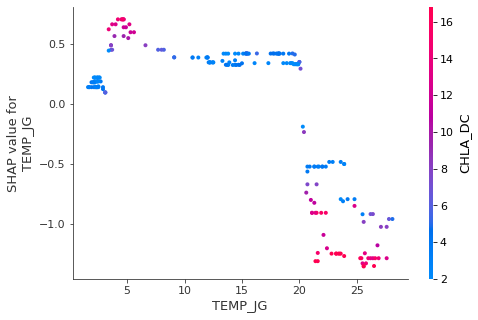

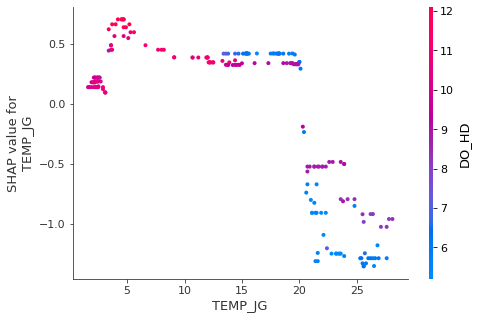

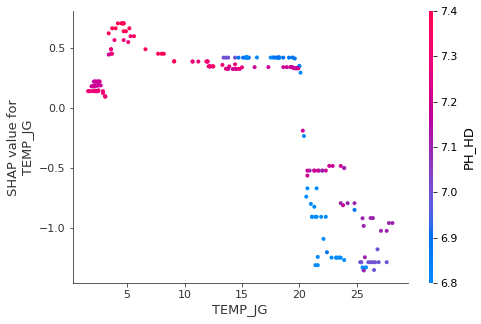

In [ ]:
inds = shap.approximate_interactions("TEMP_JG", shap_values, x_test)
for i in range(3):
  shap.dependence_plot("TEMP_JG", shap_values, x_test, interaction_index=inds[i])

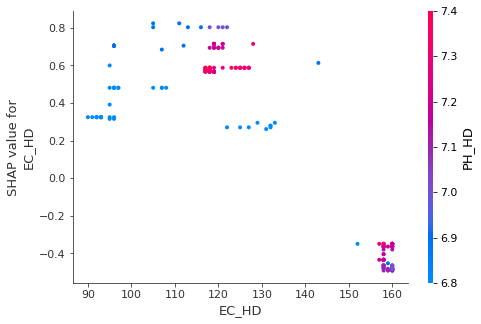

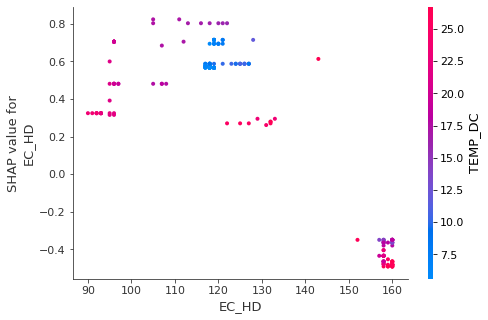

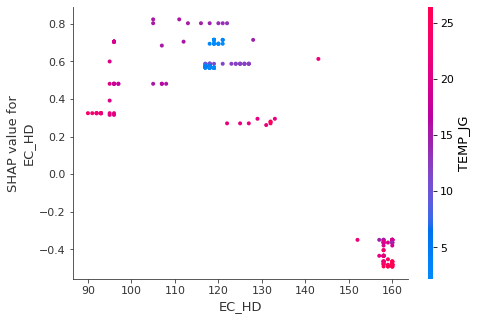

In [ ]:
inds = shap.approximate_interactions("EC_HD", shap_values, x_test)
for i in range(3):
  shap.dependence_plot("EC_HD", shap_values, x_test, interaction_index=inds[i])

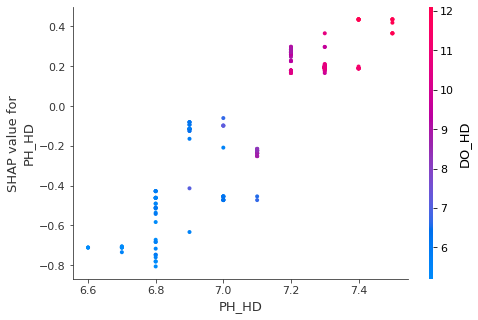

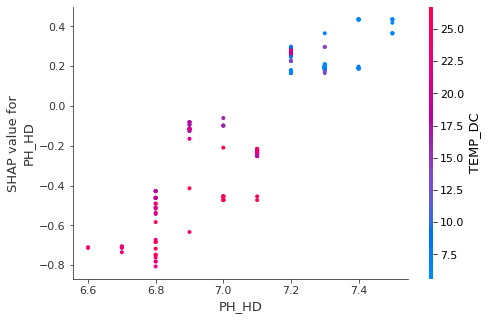

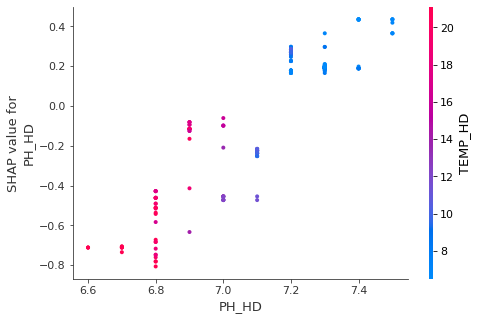

In [ ]:
inds = shap.approximate_interactions("PH_HD", shap_values, x_test)
for i in range(3):
  shap.dependence_plot("PH_HD", shap_values, x_test, interaction_index=inds[i])

In [ ]:
#shap.dependence_plot("BMI", shap_values, X, display_features=X_display, show=False) #display_features = X_display : 이진 분류 변수의 그림 그릴 때 사용

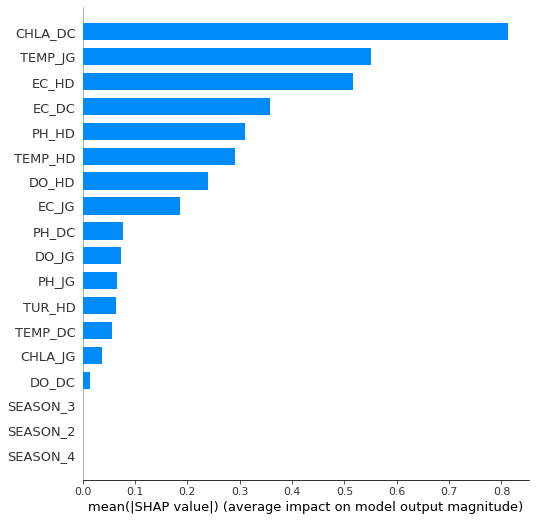

In [ ]:
shap.summary_plot(shap_values, x_train, plot_type='bar')

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, x_test)